This notebook contains all the scripts in the directory chained together. 


Preprocessing.py

In [8]:
import matplotlib.pyplot as plt
import numpy as np
THRESHOLD_MISSING = 5
THRESHOLD_CORRELATION = 0.90
FACTOR = 1000
MU = 0
SIGMA = 0.1

def clean_FAOSTAT(df):
    #keep data only from FAO TIER 1 source, original data contains data for same year but from multiple sources
    #both sources have similar measurements
    #FAO TIER 1 is more complete than UNFCCC
    cleaned_df = df[df["Source Code"] == 3050] #FAO TIER 1
    #drop numeric codes that do not apply
    cleaned_df = cleaned_df.drop(['Area Code', 'Item Code', 'Source Code', 'Source', 'Element Code'], axis=1)
    #extract columns belonging to the USA
    cleaned_df = cleaned_df[cleaned_df['Area'] == 'United States of America']
    #rename Items column to Activity
    cleaned_df.rename(columns={'Item':'Activity'}, inplace=True)
    #reset the index
    cleaned_df = cleaned_df.reset_index(drop=True)
    return cleaned_df

#Clean up the emissions dataframe consisting of only emission activity/element and year
def create_emissions_frame(columns, df):
    df['Emission'] = df[columns[0]].astype(str) + '_' + df[columns[1]]
    df.drop(columns, axis=1, inplace=True)
    df.insert(0,'Emission', df.pop('Emission'))
    df = drop_year_no_data(df)
    df = df.set_index('Emission').transpose().fillna(0).reset_index()
    df['index'] = df['index'].str.lstrip('Y')
    return df.rename(columns={'index':'Year'}).set_index('Year')

#filter the emissions list to only contain the biggest contributers to argiculture
def list_emissions(emission_name, emission_activity_and_type):
    return list(filter(lambda emission: emission_name in emission[1],emission_activity_and_type))

#Because Area and Unit are the same value in every row (USA, Kilotonnes respectively), I will drop those. Set the column indicies to Activity
def create_emission_df(df, emission_list):
    return df[df['Element'].isin([el[1] for el in emission_list])].drop(['Area', 'Unit'], axis=1).reset_index(drop=True)

#drop columns where more than THRESHOLD_MISSING % of data is missing
def drop_year_no_data(df):
    #df columns currently are Year 19XX/2XXX
    for column in df:
        #if there is too much data missing for a particular year, drop it
        #initial check showed most data prior to 1990 is missing & is effectively being dropped
        if check_percent_data_missing(df[column]) > THRESHOLD_MISSING:
            df.drop(column, axis=1, inplace=True)
    return df

#check % of data missing in each column
def check_percent_data_missing(df):
    return df.isnull().sum()/df.shape[0] * 100

#a lot of data in set relates to emissions due to fires, keep emissions only related to agriculture
def keep_agriculture_data(df):
    columns_to_keep = []
    for column in df:
        if "agricult" in str(column).lower() or "farm" in str(column).lower():
            columns_to_keep.append(str(column))
    cleaned_df = df[columns_to_keep]
    return cleaned_df

#a lot of data in set relates to emissions due to fires, keep emissions only related to agriculture
def remove_fire_data(df):
    for column in df:
        #LULUCF emissions are a metric of how much emissions are sunk by forests
        if "fire" in str(column).lower() or "burn" in str(column).lower() or "forest" in str(column).lower() or "LULUCF" in str(column).lower():
            df.drop(column, axis=1, inplace=True)
    return df

def drop_correlations(df):
    # create correlation matrix
    corr_matrix = df.corr().abs()
    # select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    # find features with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > THRESHOLD_CORRELATION)]
    df.drop(to_drop, axis=1, inplace=True)
    return df

def merge_df (crops_df, emission_df, drop_columns):
    #drop data from last 3 years, so that the crop yields and emission df year data matches
    #1990-2016
    emission_df.drop(emission_df.tail(3).index,inplace=True)
    #reset index as column to merge on
    emission_df = emission_df.reset_index(drop=False)
    emission_crop_df=pd.merge(crops_df, emission_df, left_index=True, right_index=True)
    emission_crop_df.drop(columns= drop_columns,inplace=True) 
    return emission_crop_df

def augment_df(emission_crop_df):
    #extend the df by a factor to compensate for small data set
    emission_crop_extended = pd.DataFrame(np.repeat(emission_crop_df.values, FACTOR, axis=0))
    emission_crop_extended.columns = emission_crop_df.columns
    #add random Gaussian noise to all entries so that we are not working with exact copies of the data
    np.random.seed(3)
    noise = np.random.normal(MU, SIGMA, [emission_crop_extended.shape[0],emission_crop_extended.shape[1]])
    emission_crop_noisy = emission_crop_extended.astype(float) + noise
    return emission_crop_noisy

Model.py

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import math

def run_model(df, features, labels):
	X = df[features]
	y = df[labels]
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 21)
	sc = StandardScaler()
	X_train = sc.fit_transform(X_train)
	X_test = sc.transform(X_test)
	regr = LinearRegression()
	regr.fit(X_train, y_train)
	y_pred=regr.predict(X_test)
	score = regr.score(X_test, y_test)
	mse = mean_squared_error(y_test, y_pred)
	mrse = math.sqrt(mse)
	return y_pred, y_test, score, mse, mrse

Main.py

In [10]:
import pandas as pd

df = pd.read_csv('FAOSTAT_data_1961_2019.csv')
cleaned_df = clean_FAOSTAT(df)

#create an emission activity and emission type list. Each value is a tuple, 0th -> activity, 1st -> type of emission
emission_activity_and_type = list(cleaned_df.groupby(['Activity','Element']).indices.keys())

'''Anthropogenic climate change is caused by multiple climate pollutants, with CO2, CH4, and N2O the three largest individual contributors to global warming. Agriculture and food production is associated with all three of these gases, but direct agricultural emissions are unusual in being dominated by CH4 and N2O.'''

#filter the emissions list to only contain the biggest contributers to argiculture
CO2_gas_list = list_emissions("CO2", emission_activity_and_type)
CH4_gas_list = list_emissions("CH4", emission_activity_and_type)
N2O_gas_list = list_emissions("N2O", emission_activity_and_type)

#Because Area and Unit are the same value in every row (USA, Kilotonnes respectively), I will drop those. Set the column indicies to Activity
CO2_df = create_emission_df(cleaned_df, CO2_gas_list)
CH4_df = create_emission_df(cleaned_df, CH4_gas_list)
N2O_df = create_emission_df(cleaned_df, N2O_gas_list)

#filter the emissions list to only contain the biggest contributers to argiculture
CO2_df = create_emissions_frame(['Activity', 'Element'], CO2_df)
CH4_df = create_emissions_frame(['Activity', 'Element'], CH4_df)
N2O_df = create_emissions_frame(['Activity', 'Element'], N2O_df)

#drop highly correlated features
CO2_df = drop_correlations(CO2_df)
CH4_df = drop_correlations(CH4_df)
N2O_df = drop_correlations(N2O_df)

#the features that remain are not related to forests and fires but agrivulture
#all features have a correlation less than abs(THRESHOLD_CORRELATION)
CO2_df = remove_fire_data(CO2_df)
CH4_df = remove_fire_data(CH4_df)
N2O_df = remove_fire_data(N2O_df)

#import crop yields data
prod_amt=pd.read_csv('clean_production.csv')
prod_amt.drop(columns=['Unnamed: 0'],inplace=True)
prod_amt.rename(columns={"YEAR":"Year"},inplace=True)
prod_amt['Year']=prod_amt['Year'].astype("str")

<ipython-input-8-ba6a91682522>:77: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


# Calling of Model with Score

CO2 levels and crops prediction model
Note that if model is re-run the numbers might be slightly different since the data has added Gaussian noise, random seed is provided.

In [11]:
#CO2 and crop yields
#merge the two df
drop_columns_CO2 = 'Year_x'
crops_CO2_df = merge_df(prod_amt, CO2_df, drop_columns_CO2)
#augment the data since it has one entry per year between 1990 and 2016
crops_CO2_augmented = augment_df(crops_CO2_df)
#select features for CO2
features_CO2 = ["On-farm energy use_Emissions (CO2)",                        
				"IPCC Agriculture_Emissions (CO2eq) (AR5)",       
				"Emissions on agricultural land_Emissions (CO2)", 
				"Farm-gate emissions_Emissions (CO2eq) (AR5)"]
#labels apply to all models
labels_all = ['RICE_TONNE_HA',
			  'WHEAT_TONNE_HA',
			  'MAIZE_TONNE_HA',
			  'SOYBEAN_TONNE_HA']
#build linear regression model for crop yields and CO2
CO2_pred, CO2_test, crops_CO2_score, crops_CO2_mse, crops_CO2_mrse = run_model(crops_CO2_df, features_CO2, labels_all)
print("Crops_CO2_r^2_score = ", crops_CO2_score, 
	  "Crops_CO2_mse = ", crops_CO2_mse, 
	  "Crops_CO2_mrse = ", crops_CO2_mrse)

Crops_CO2_r^2_score =  0.6286858226823003 Crops_CO2_mse =  0.22589663696197151 Crops_CO2_mrse =  0.47528584763484333


CH4 levels and crops prediction model
Note that if model is re-run the numbers might be slightly different since the data has added Gaussian noise, random seed is provided.

In [12]:
#crop yields and CH4
#merge crop yield and CH4
drop_columns_CH4 = ["Year_x", "Year_y"]
crops_CH4_df = merge_df(prod_amt, CH4_df, drop_columns_CH4)
#augment data frame since it has one entry per years 1990-2016
crops_CH4_augmented = augment_df(crops_CH4_df)
#select features sepecific to CH4
features_CH4 = ["Enteric Fermentation_Emissions (CH4)",    
				"Manure Management_Emissions (CH4)",
				"On-farm energy use_Emissions (CH4)" ]
#build linear regression model
CH4_pred, CH4_test, crops_CH4_score, crops_CH4_mse, crops_CH4_mrse = run_model(crops_CH4_df, features_CH4, labels_all)
print("Crops_CH4_r^2_score = ", crops_CH4_score, 
	  "Crops_CH4_mse = ", crops_CH4_mse, 
	  "Crops_CH4_mrse = ", crops_CH4_mrse)

Crops_CH4_r^2_score =  0.4939693123010209 Crops_CH4_mse =  0.4047608294251469 Crops_CH4_mrse =  0.6362081651669891


N2O levels and crops prediction model
Note that if model is re-run the numbers might be slightly different since the data has added Gaussian noise, random seed is provided.

In [13]:
#crop yields and N2O
#merge crop yields and N20
drop_columns_N2O = ["Year_x", "Year_y"]
crops_N2O_df = merge_df(prod_amt, N2O_df, drop_columns_N2O)
#augment data frame since it has one entry per years 1990-2016
crops_N2O_augmented = augment_df(crops_N2O_df)
#select features specific to N2O
features_N2O = ['Manure Management_Emissions (N2O)',
				'Synthetic Fertilizers_Direct emissions (N2O)',
				'On-farm energy use_Emissions (N2O)',
				'Manure applied to Soils_Direct emissions (N2O)',
				'Crop Residues_Direct emissions (N2O)',
				'Drained organic soils (N2O)_Emissions (N2O)',
				'IPCC Agriculture_Direct emissions (N2O)']
#build linear regression model for N2O
N2O_pred, N2O_test, crops_N2O_score, crops_N2O_mse, crops_N2O_mrse = run_model(crops_N2O_df, features_N2O, labels_all)
print("Crops_N2O_r^2_score = ", crops_N2O_score, 
	  "Crops_N2O_mse = ", crops_N2O_mse, 
	  "Crops_N2O_mrse = ", crops_N2O_mrse)

Crops_N2O_r^2_score =  0.8308109396482756 Crops_N2O_mse =  0.07437804321867085 Crops_N2O_mrse =  0.2727233822367837


# Functions for Plotting and Visual Analysis

In [62]:
def plot_pred_vs_act(dfplot, title):
  dfplot.plot(kind='bar')
  plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
  plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
  plt.title(title)
  plt.ylabel('Values')
  plt.legend(loc='lower right')
  plt.show()

def create_bar(df_bar1,df_bar2,title):
  df_plot_bar_fun=pd.DataFrame(df_bar1,df_bar2)
  df_plot_bar_fun.reset_index(inplace=True)
  df_plot_bar_fun.set_axis(['actual', 'Predicted'], axis='columns', inplace=True)
  plot_pred_vs_act(df_plot_bar_fun,title)

def create_scatter(df_def,title):
  plt.scatter(df_def['actual'], df_def['Predicted'])
  plt.ylabel("Values")
  plt.title(title)
  plt.show()

def plot_prediction(rice, wheat, maize, soybean, title):
    x = range(len(rice))
    plt.plot(x, rice, label="Rice")
    plt.plot(x, wheat, label="Wheat")
    plt.plot(x, maize, label="Maize")
    plt.plot(x, soybean, label="Soybean")
    # plt.xlabel("TONNE_HA")
    plt.legend()
    # plt.ylabel(label_y)
    plt.title(title)
    axes = plt.axes()
    axes.xaxis.set_major_locator(plt.MaxNLocator(10))
    plt.show()

def plot_test(rice, wheat, maize, soybean, title):
    x = range(len(rice))
    plt.plot(x, rice, label="Rice")
    plt.plot(x, wheat, label="Wheat")
    plt.plot(x, maize, label="Maize")
    plt.plot(x, soybean, label="Soybean")
    # plt.xlabel("Year")
    plt.legend()
    # plt.ylabel("TONNE_HA")
    plt.title(title)
    axes = plt.axes()
    axes.xaxis.set_major_locator(plt.MaxNLocator(10))
    plt.show()

def extract_crops_from_prediction(predictions):
  rice = []
  wheat = []
  maize = []
  soybean = []
  for prediction in predictions:
    rice.append(prediction[0])
    wheat.append(prediction[1])
    maize.append(prediction[2])
    soybean.append(prediction[3])
  return rice, wheat, maize, soybean

def extract_crops_from_test(test_data):
  rice = test_data["RICE_TONNE_HA"]
  wheat = test_data["WHEAT_TONNE_HA"]
  maize = test_data["MAIZE_TONNE_HA"]
  soybean = test_data["SOYBEAN_TONNE_HA"]
  return rice, wheat, maize, soybean

In [15]:
N2O_rice_pred, N2O_wheat_pred, N2O_maize_pred, N2O_soybean_pred = extract_crops_from_prediction(N2O_pred)
N2O_rice_test, N2O_wheat_test, N2O_maize_test, N2O_soybean_test = extract_crops_from_test(N2O_test)

In [50]:
CO2_rice_pred, CO2_wheat_pred, CO2_maize_pred, CO2_soybean_pred = extract_crops_from_prediction(CO2_pred)
CO2_rice_test, CO2_wheat_test, CO2_maize_test, CO2_soybean_test = extract_crops_from_test(CO2_test)

In [51]:
CH4_rice_pred, CH4_wheat_pred, CH4maize_pred, CH4_soybean_pred = extract_crops_from_prediction(CH4_pred)
CH4_rice_test, CH4_wheat_test, CH4_maize_test, CH4_soybean_test = extract_crops_from_test(CH4_test)

# Bar Chart Function Calls

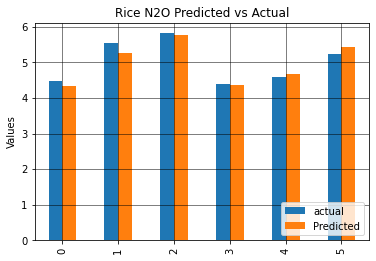

In [41]:
create_bar(N2O_rice_pred,N2O_rice_test,'Rice N2O Predicted vs Actual')

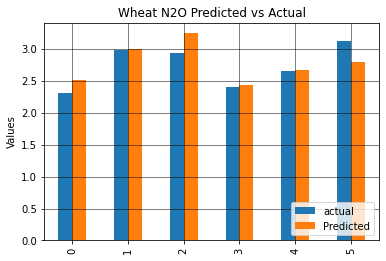

In [42]:
create_bar(N2O_wheat_pred,N2O_wheat_test,'Wheat N2O Predicted vs Actual')

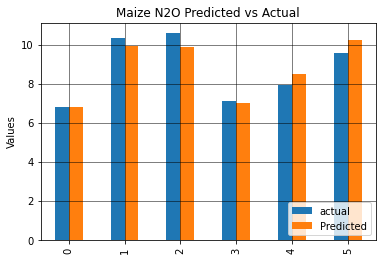

In [43]:
create_bar(N2O_maize_pred,N2O_maize_test,'Maize N2O Predicted vs Actual')

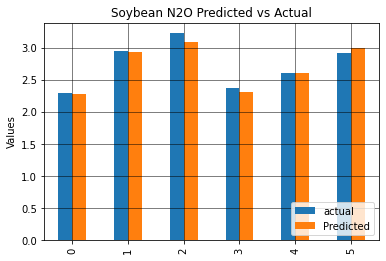

In [45]:
create_bar(N2O_soybean_pred,N2O_soybean_test,'Soybean N2O Predicted vs Actual')

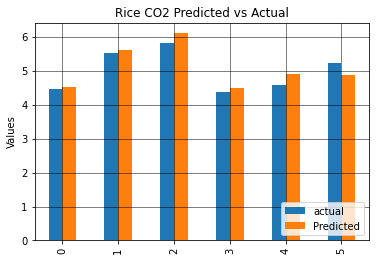

In [46]:
create_bar(CO2_rice_pred,CO2_rice_test,'Rice CO2 Predicted vs Actual')

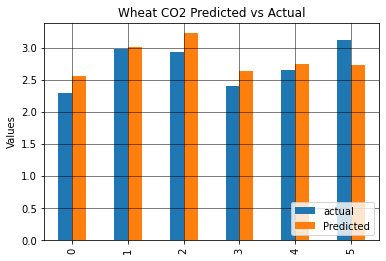

In [47]:
create_bar(CO2_wheat_pred,CO2_wheat_test,'Wheat CO2 Predicted vs Actual')

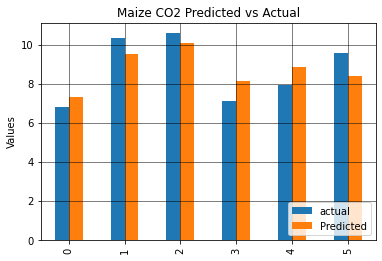

In [48]:
create_bar(CO2_maize_pred,CO2_maize_test,'Maize CO2 Predicted vs Actual')

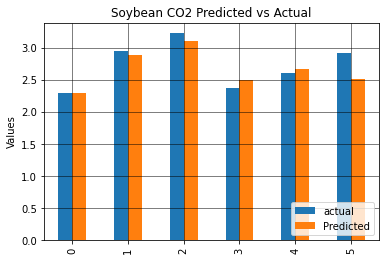

In [49]:
create_bar(CO2_soybean_pred,CO2_soybean_test,'Soybean CO2 Predicted vs Actual')

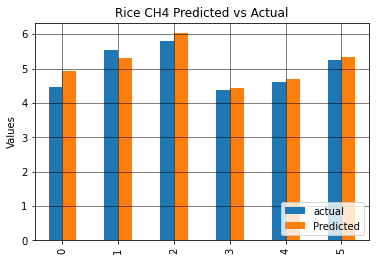

In [52]:
create_bar(CH4_rice_pred,CH4_rice_test,'Rice CH4 Predicted vs Actual')

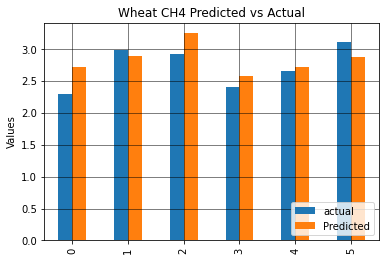

In [53]:
create_bar(CH4_wheat_pred,CH4_wheat_test,'Wheat CH4 Predicted vs Actual')

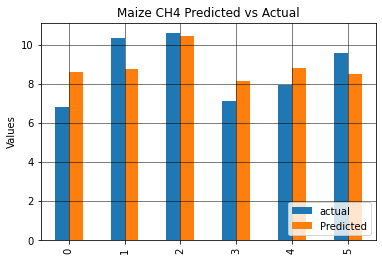

In [56]:
create_bar(CH4maize_pred,CH4_maize_test,'Maize CH4 Predicted vs Actual')

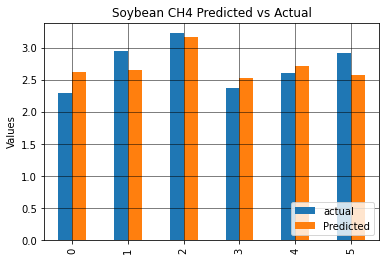

In [54]:
create_bar(CH4_soybean_pred,CH4_soybean_test,'Soybean CH4 Predicted vs Actual')

# ScatterPlots

In [30]:
n2o_list=[df_plot_bar_No2_rice,df_plot_bar_No2_wheat,df_plot_bar_No2_maize,df_plot_bar_No2_soybean]
df_allN20=pd.concat(n2o_list)

In [31]:
CH4_list=[df_plot_bar_CH4_rice,df_plot_bar_CH4_wheat,df_plot_bar_CH4_maize,df_plot_bar_CH4_soybean]
df_allCH4=pd.concat(CH4_list)

In [32]:
CO2_list=[df_plot_bar_CO2_rice,df_plot_bar_CO2_wheat,df_plot_bar_CO2_maize,df_plot_bar_CO2_soybean]
df_allCO2=pd.concat(CO2_list)

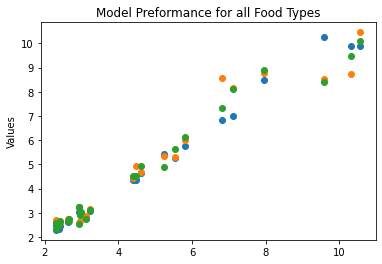

In [67]:
plt.scatter(df_allN20['actual'], df_allN20['Predicted'])
plt.scatter(df_allCH4['actual'], df_allCH4['Predicted'])
plt.scatter(df_allCO2['actual'], df_allCO2['Predicted'])
plt.ylabel("Values")
plt.title("Model Preformance for all Food Types")
plt.show()

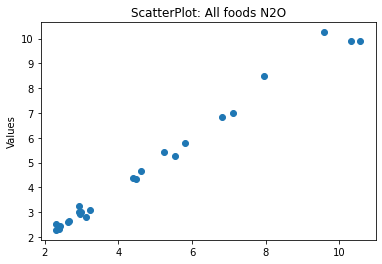

In [65]:
create_scatter(df_allN20,"ScatterPlot: All foods N2O")

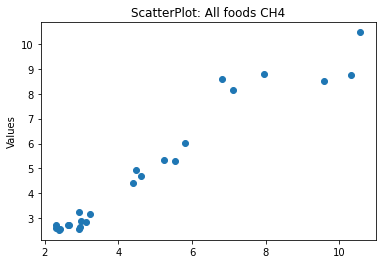

In [64]:
create_scatter(df_allCH4,"ScatterPlot: All foods CH4")

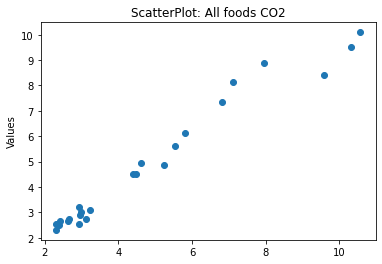

In [63]:
create_scatter(df_allCO2,"ScatterPlot: All foods CO2")